In [2]:
import pandas as pd
import os

modules = pd.read_csv("2st_total_experiment_modules.csv", index_col=0)
rack = pd.read_excel("(220406)KETI 시험의뢰#1_2차시험_랙 데이터.xlsx", index_col = 0)

In [4]:
modules.columns

Index(['Module', 'Cell_Voltage1', 'Cell_Voltage2', 'Cell_Voltage3',
       'Cell_Voltage4', 'Cell_Voltage5', 'Cell_Voltage6', 'Cell_Voltage7',
       'Cell_Voltage8', 'Cell_Voltage9', 'Cell_Voltage10', 'Cell_Voltage11',
       'Cell_Voltage12', 'MIN_CELL_TEMP', 'MAX_CELL_TEMP', 'MIN_CELL_VOLT',
       'MIN_CELL_Volt_Pt', 'MAX_CELL_VOLT', 'MAX_CELL_Volt_Pt', 'Voltage'],
      dtype='object')

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


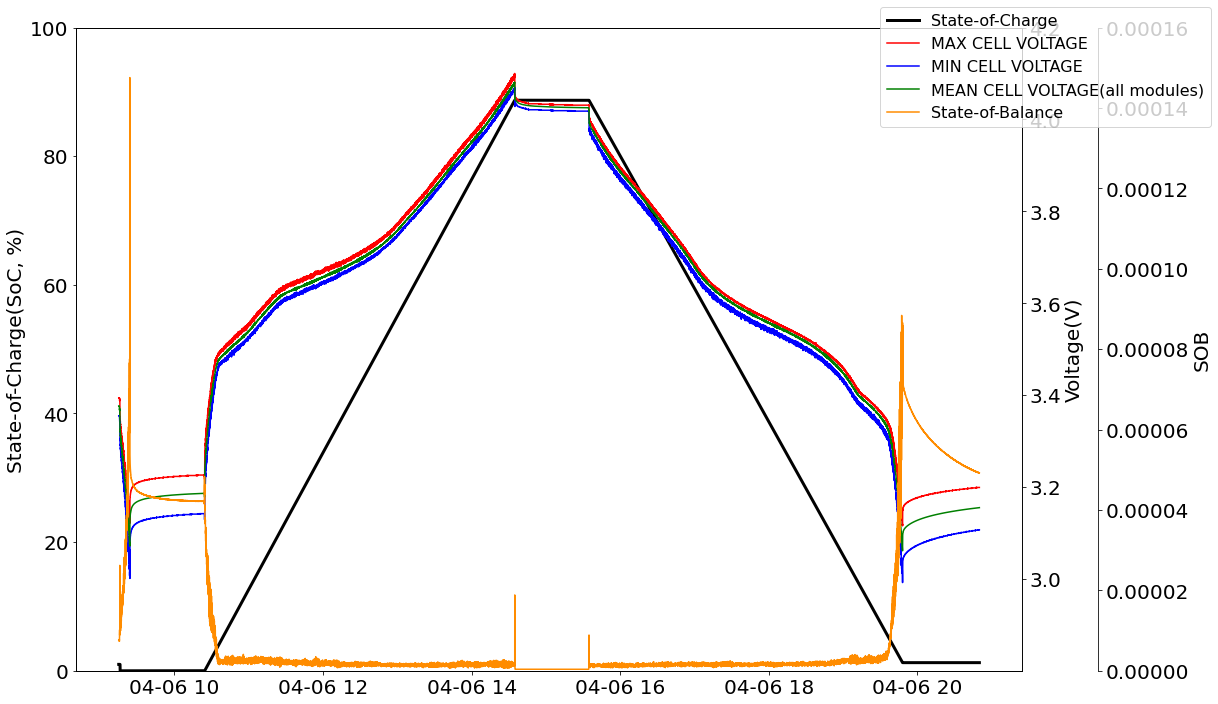

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpl_toolkits import axisartist
import matplotlib.pylab as plt
import re

cmap = plt.get_cmap('jet_r')


def plot_mean_voltage_modules(modules):
    module_mean_voltage = pd.DataFrame()
    cell_voltages = [ f'Cell_Voltage{i}' for i in range(1,13)]
    for i in range(1,modules.Module.max()+1):
        temp = modules.loc[modules['Module']==i]
        module_mean = temp[cell_voltages].mean(axis=1)
        module_mean_voltage = pd.concat([module_mean_voltage,module_mean], axis=1)
    ax2.plot(rack.index, module_mean_voltage.mean(axis=1)[:-1], color='green', label="MEAN CELL VOLTAGE(all modules)")

def plot_modules_sob(modules):
    module_voltage = pd.DataFrame()
    cell_voltages = [ f'Cell_Voltage{i}' for i in range(1,13)]
    for i in range(1,modules.Module.max()+1):
        temp = modules.loc[modules['Module']==i][:-1]
        module_cell_voltage = temp[cell_voltages]
        
        module_cell_voltage.rename(columns = lambda x: x[:12]+f"{int(x[12:])+(i-1)*12}", inplace = True)
        
        module_voltage = pd.concat([module_voltage,module_cell_voltage], axis=1)

    myu = module_voltage.mean(axis=1)
    
    #######################################################################################################
    
    module_sub = module_voltage.sub(myu, axis=0)

    module_standard = module_sub.div(myu, axis=0)

    module_sob = module_standard.mul(module_standard, axis=0).mean(axis=1)
    
    return module_sob
        
        
    
plt.rcParams['figure.figsize'] = [16, 10]
plt.rc('font', size=20) 

fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax3 = ax1.twinx()

#############################################################################################################

start_idx = 4164
end_idx = 41698

coulomb_counting = pd.DataFrame(index = rack.index, columns=["Coulomb counting SOC"])
coulomb_counting.loc[:start_idx,"Coulomb counting SOC"] = rack.iloc[:start_idx]["RACK_SOC"]

for i in range(start_idx,end_idx+1):
    coulomb_counting.iloc[i]["Coulomb counting SOC"] = coulomb_counting.iloc[i-1]["Coulomb counting SOC"] + rack.iloc[i]["RACK_CURRENT"]/60/3600/3.75*100

ax1.plot(coulomb_counting.index, coulomb_counting["Coulomb counting SOC"], label="State-of-Charge", color='black', linewidth=3)

ax1.set_ylabel("State-of-Charge(SoC, %)")
ax1.set_yticks([0,20,40,60,80,100])
ax1.set_ylim([0,100])

#############################################################################################################

ax2.plot(rack.index, rack["MAX_CELL_VOLT"], color='red' , label="MAX CELL VOLTAGE")
ax2.plot(rack.index, rack["MIN_CELL_VOLT"], color='blue', label="MIN CELL VOLTAGE")
plot_mean_voltage_modules(modules)

ax2.set_ylabel("Voltage(V)")
ax2.set_yticks([3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])
ax2.set_ylim([2.8,4.2])

sob = plot_modules_sob(modules)

ax3.set_ylabel("SOB")
ax3.set_yticks([0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012, 0.00014, 0.00016])
ax3.set_ylim([0,0.00016])

ax3.plot(rack.index, sob.values, color = "darkorange", label="State-of-Balance")

fig.tight_layout()
fig.legend(fontsize = 16)

plt.subplots_adjust(right=0.9)
ax3.spines["right"].set_position(("axes", 1.08))
plt.savefig("./2st_fig/rack/rack SOC and SOB to Modules.jpg", dpi=256)